In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import argparse
import random
import time
from collections import Counter
from datetime import datetime
%matplotlib inline
np.random.seed(5)
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [2]:
train = pd.read_csv('./data/Taobao/UserBehavior.csv', sep=',', names=["UserId", "ItemId", "CategoryId", "BehaviorType", "Timestamp"] )

In [3]:
# 按照行为
# train = train.sample(frac=0.7, replace=False, weights=None, random_state=None, axis=0)
all_user = train.UserId.unique()
# selected_user = np.random.choice(all_user, int(0.7*len(all_user)))
selected_user = np.random.choice(all_user, 100000)
train = train[train.UserId.isin(selected_user)]

In [4]:
train.describe()

,UserId,ItemId,CategoryId,Timestamp
count,9604079.00,9604079.00,9604079.00,9604079.00
mean,507425.53,2579543.03,2700022.00,1511945000.76
std,293854.57,1487554.71,1462526.15,7462708.61
min,3.00,4.00,80.00,-2134949234.00
25%,252541.00,1296406.00,1320530.00,1511762403.00
50%,504102.00,2579668.00,2678261.00,1511965140.00
75%,759352.00,3860974.00,4145813.00,1512179487.00
max,1018008.00,5163068.00,5161669.00,2108304574.00


In [5]:
# 2017.11.25 to 2017.12.03
def getTimestamp(value):
    d = datetime.strptime(value, "%Y.%m.%d %H:%M:%S") 
    t = d.timetuple() 
    span = int(time.mktime(t)) 
    print(span)
    return span
    
leftValue = '2017.11.25 00:00:00'
rightValue = '2017.12.04 00:00:00'
span_left = getTimestamp(leftValue)
span_right = getTimestamp(rightValue)

train = train[train['Timestamp'].between(span_left, span_right, inclusive=True)]

1511539200
1512316800


In [6]:
day = 1
min_timestamp = train.Timestamp.min()
time_id = [int(math.floor((t-min_timestamp) / (86400*day))) for t in train['Timestamp']]
train['TimeId'] = time_id

session_id = [str(uid)+'_'+str(tid) for uid, tid in zip(train['UserId'], train['TimeId'])]
train['SessionId'] = session_id
train = train[["SessionId", "UserId", "ItemId", "Timestamp", "BehaviorType",'TimeId', "CategoryId"]]

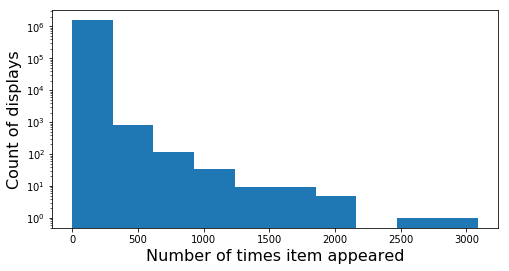

In [7]:
items = train.ItemId.value_counts()
plt.figure(figsize=(8, 4))
plt.hist(items.values, bins=10, log=True)
plt.xlabel('Number of times item appeared', fontsize=16)
plt.ylabel('Count of displays', fontsize=16)
plt.show()

In [8]:
item_cnt = len(train.ItemId.unique())
items = train.ItemId.value_counts()
print(sum(items >200), sum(items >200)/item_cnt)
print(sum(items <10), sum(items<10)/item_cnt)

2390 0.0015329592656163008
1358791 0.8715360893247026


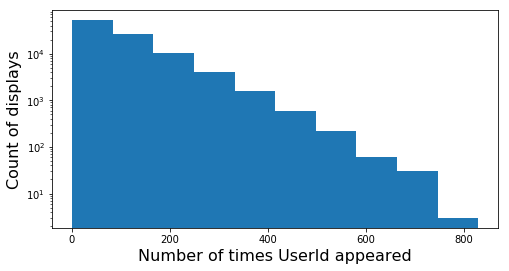

In [9]:
items = train.UserId.value_counts()
plt.figure(figsize=(8, 4))
plt.hist(items.values, bins=10, log=True)
plt.xlabel('Number of times UserId appeared', fontsize=16)
plt.ylabel('Count of displays', fontsize=16)
plt.show()

In [10]:
user_cnt = len(train.UserId.unique())
items = train.UserId.value_counts()
print(sum(items<10)/user_cnt)
print(sum(items<3)/user_cnt, sum(items>=3))
print(sum(items>=40)/user_cnt, sum(items>=40))

0.019000126246686025
0.0002630139292176914 95027
0.7475697512940286 71058


In [86]:
ITEM_MIN = 44
USER_MIN = 25

In [87]:
train = train[train['ItemId'].groupby(train['ItemId']).transform('size')>= ITEM_MIN]

In [88]:
train = train[train['UserId'].groupby(train['UserId']).transform('size')>= USER_MIN]

In [89]:
max_length = 50
train = train[train['SessionId'].groupby(train['SessionId']).transform('size')>1]
train = train[train['SessionId'].groupby(train['SessionId']).transform('size')<max_length]

In [90]:
user_cnt = len(train.UserId.unique())
item_cnt = len(train.ItemId.unique())
cate_cnt = len(train.CategoryId.unique())
session_cnt = len(train.SessionId.unique())
all_cnt = train.shape

print("用户数量：", user_cnt)
print("item数量：", item_cnt)
print("cate数量：", cate_cnt)
print("session数量：", session_cnt)
print("所有行为数", all_cnt[0])

session_cnt_dict = train['SessionId'].value_counts()
user_cnt_dic = train["UserId"].value_counts()
item_cnt_dic = train["ItemId"].value_counts()

print("session平均长度", all_cnt[0]/session_cnt)
print("user平均session个数", session_cnt/user_cnt)
print("user平均行为个数", all_cnt[0]/user_cnt)

用户数量： 31511
item数量： 18461
cate数量： 868
session数量： 183791
所有行为数 1668728
session平均长度 9.079487026024125
user平均session个数 5.832598140331948
user平均行为个数 52.95699914315636


In [91]:
Behaviortype_cnt = train["BehaviorType"].value_counts()
print(Behaviortype_cnt)
print(train['TimeId'].value_counts())

pv      1507137
cart      89886
fav       48707
buy       22998
Name: BehaviorType, dtype: int64
7    212325
8    207610
6    185636
5    183219
1    183123
0    177762
4    175641
2    175219
3    168193
Name: TimeId, dtype: int64


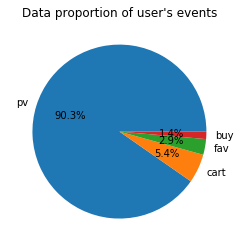

In [92]:
indexes = Behaviortype_cnt.index
values = Behaviortype_cnt.values
plt.subplots(figsize=(4,4))
# Plot
plt.pie(values, labels=indexes,startangle=0, autopct='%.1f%%')
 
plt.title("Data proportion of user's events")
plt.show()

In [93]:
print("-----user的行为-------")
for i,j in Behaviortype_cnt.items():
    print(i, j/user_cnt)
print("\n-----session的行为-----")
for i,j in Behaviortype_cnt.items():
    print(i, j/session_cnt)

-----user的行为-------
pv 47.82891688616674
cart 2.8525276887436135
fav 1.545714195043001
buy 0.7298403732030084

-----session的行为-----
pv 8.200276400911905
cart 0.48906638518752277
fav 0.2650129766963562
buy 0.1251312632283409


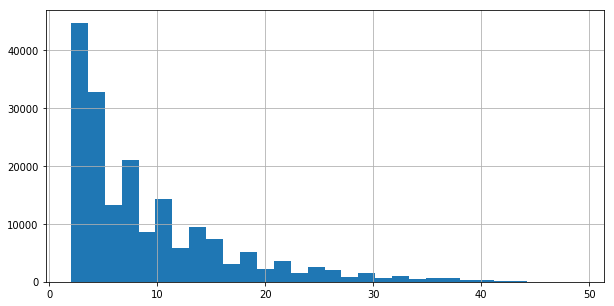

In [94]:
session_cnt_dict.hist(bins=30, figsize=(10,5))

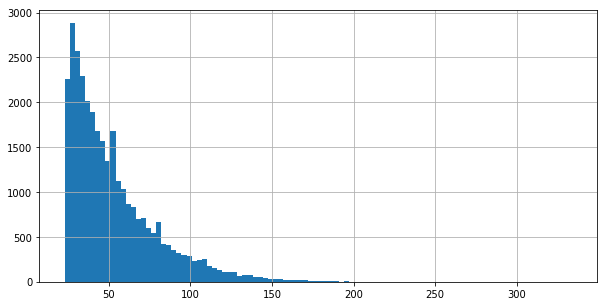

In [95]:
user_cnt_dic.hist(bins=100, figsize=(10,5))

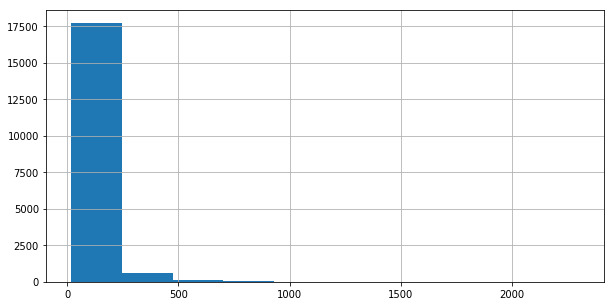

In [96]:
item_cnt_dic.hist(bins=10, figsize=(10,5))

In [97]:
user_week = train["TimeId"].groupby(train["UserId"]).unique()
multiweek_dict = {}
for i, v in user_week.items():
    l = len(v)
    if l in multiweek_dict:
        multiweek_dict[l] += 1
    else:
        multiweek_dict[l] = 1
print(multiweek_dict)
# 用户非常活跃

{5: 6384, 7: 5776, 6: 6647, 4: 4509, 3: 2075, 8: 3757, 9: 1795, 2: 517, 1: 51}


save file

In [98]:
# split train and test

In [99]:
tmax = train.TimeId.max()
session_max_times = train.groupby('SessionId').TimeId.max()

session_train = session_max_times[session_max_times < tmax].index
session_holdout = session_max_times[session_max_times >= tmax].index
train_tr = train[train['SessionId'].isin(session_train)]
holdout_data = train[train['SessionId'].isin(session_holdout)]

print('Number of train/test: {}/{}'.format(len(train_tr), len(holdout_data)))

Number of train/test: 1461118/207610


In [100]:
train_tr = train_tr[train_tr['ItemId'].groupby(train_tr['ItemId']).transform('size') >= ITEM_MIN]
train_tr = train_tr[train_tr['SessionId'].groupby(train_tr['SessionId']).transform('size') > 1]

print('Item size in train data: {}'.format(train_tr['ItemId'].nunique()))


Item size in train data: 13743


In [101]:
print('Item size in train data: {}'.format(train_tr['ItemId'].nunique()))

Item size in train data: 13743


In [102]:
train_item_counter = Counter(train_tr.ItemId)
to_predict = Counter(el for el in train_item_counter.elements() if train_item_counter[el] >= ITEM_MIN).keys()
print('Size of to predict: {}'.format(len(to_predict)))

# split holdout to valid and test.
holdout_cn = holdout_data.SessionId.nunique()
holdout_ids = holdout_data.SessionId.unique()
np.random.shuffle(holdout_ids)
valid_cn = int(holdout_cn * 0.5)
session_valid = holdout_ids[0: valid_cn]
session_test = holdout_ids[valid_cn:]
valid = holdout_data[holdout_data['SessionId'].isin(session_valid)]
test = holdout_data[holdout_data['SessionId'].isin(session_test)]

valid = valid[valid['ItemId'].isin(to_predict)]
valid = valid[valid['SessionId'].groupby(valid['SessionId']).transform('size') > 1]

test = test[test['ItemId'].isin(to_predict)]
test = test[test['SessionId'].groupby(test['SessionId']).transform('size') > 1]

Size of to predict: 13596


In [103]:
print('Train set\n\tEvents: {}\n\tSessions: {}\n\tUsers: {}\n\tItems: {}\n\tAvg length: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.UserId.nunique(),train_tr.ItemId.nunique(),
                                                                                      train_tr.groupby('SessionId').size().mean()))
print('Valid set\n\tEvents: {}\n\tSessions: {}\n\tUsers: {}\n\tItems: {}\n\tAvg length: {}'.format(len(valid), valid.SessionId.nunique(),valid.UserId.nunique(), valid.ItemId.nunique(), valid.groupby('SessionId').size().mean()))
print('Test set\n\tEvents: {}\n\tSessions: {}\n\tUsers: {}\n\tItems: {}\n\tAvg length: {}'.format(len(test), test.SessionId.nunique(), test.UserId.nunique(),test.ItemId.nunique(), test.groupby('SessionId').size().mean()))

Train set
	Events: 1275610
	Sessions: 153166
	Users: 31490
	Items: 13743
	Avg length: 8.32828434508964
Valid set
	Events: 85935
	Sessions: 10529
	Users: 10529
	Items: 12655
	Avg length: 8.161743755342387
Test set
	Events: 85720
	Sessions: 10560
	Users: 10560
	Items: 12667
	Avg length: 8.117424242424242


In [104]:
train_tr = train_tr.sort_values(by = ["SessionId","Timestamp" ], ascending = [True, True])
valid = valid.sort_values(by = ["SessionId","Timestamp" ], ascending = [True, True])
test = test.sort_values(by = ["SessionId","Timestamp" ], ascending = [True, True])

In [105]:
train_tr.to_csv('./data/Taobao/train.tsv', sep='\t', index=False)
valid.to_csv('./data/Taobao/valid.tsv', sep='\t', index=False)
test.to_csv('./data/Taobao/test.tsv', sep='\t', index=False)

In [106]:
train_tr.head()

,SessionId,UserId,ItemId,Timestamp,BehaviorType,TimeId,CategoryId
19946959,1000035_1,1000035,668820,1511672807,pv,1,4756105
19946967,1000035_1,1000035,781936,1511673333,pv,1,3607361
19946970,1000035_1,1000035,781936,1511673381,pv,1,3607361
19946971,1000035_1,1000035,3228886,1511673441,pv,1,3607361
19946973,1000035_1,1000035,671108,1511673553,pv,1,2355072


In [8]:
def select_n(df, n):
    all_user = df.SessionId.unique()
    selected_user = np.random.choice(all_user, n)
    return df[df.SessionId.isin(selected_user)]

train_fi = pd.read_csv('./data/Taobao/train.tsv', sep='\t', dtype={0: str, 1:str,  2: str, 3: np.int64,  4: str, 5: str, 6: str})
test_fi = pd.read_csv('./data/Taobao/test.tsv', sep='\t', dtype={0: str, 1:str,  2: str, 3: np.int64,  4: str, 5: str, 6: str})
valid_fi = pd.read_csv('./data/Taobao/valid.tsv', sep='\t', dtype={0: str, 1:str,  2: str, 3: np.int64,  4: str, 5: str, 6: str})

train_fi = select_n(train_fi, 1000)

to_predict = train_fi.ItemId.unique()

valid_fi = valid_fi[valid_fi['ItemId'].isin(to_predict)]
valid_fi = valid_fi[valid_fi['SessionId'].groupby(valid_fi['SessionId']).transform('size') > 1]
valid_fi = select_n(valid_fi, 1000)

test_fi = test_fi[test_fi['ItemId'].isin(to_predict)]
test_fi = test_fi[test_fi['SessionId'].groupby(test_fi['SessionId']).transform('size') > 1]
test_fi = select_n(test_fi, 1000)

def output(train_tr, df_name):
    print('{} set\n\tEvents: {}\n\tSessions: {}\n\tUsers: {}\n\tItems: {}\n\tAvg length: {}'.format(df_name, len(train_tr), train_tr.SessionId.nunique(), train_tr.UserId.nunique(),train_tr.ItemId.nunique(),
                                                                                      train_tr.groupby('SessionId').size().mean()))
output(train_fi, "train")
output(test_fi, "test")
output(valid_fi, "valid")

train set
	Events: 7445
	Sessions: 999
	Users: 997
	Items: 4750
	Avg length: 7.4524524524524525
test set
	Events: 4775
	Sessions: 991
	Users: 991
	Items: 2181
	Avg length: 4.8183652875882945
valid set
	Events: 4675
	Sessions: 991
	Users: 991
	Items: 2145
	Avg length: 4.717457114026236


In [9]:
train_fi.to_csv('./data/Taobao/train_mini.tsv', sep='\t', index=False)
valid_fi.to_csv('./data/Taobao/valid_mini.tsv', sep='\t', index=False)
test_fi.to_csv('./data/Taobao/test_mini.tsv', sep='\t', index=False)

In [7]:
behavior_cnt = train_fi['ItemId'].groupby(train_fi['UserId']).count()
behavior_ucnt = train_fi['ItemId'].groupby(train_fi['UserId']).nunique()
all_cnt = []
for i , j in behavior_cnt.items():
    all_cnt.append(behavior_ucnt[i]/behavior_cnt[i]*1.0)
print("用户重复消费占比：", 1-np.mean(all_cnt))

用户重复消费占比： 0.12518193310163828


In [26]:
d = datetime.fromtimestamp(1535416283) 
str1 = d.strftime("%Y-%m-%d %H:%M:%S.%f") 
print(str1)

2018-08-28 08:31:23.000000


In [19]:
train.head()

,UserID,ItemID,CategoryID,Behaviortype,Timestamp,TimeID,SessionId
9515559,514449,1168232,64179,pv,1511592314,0,514449_0
83164713,220332,2739898,883960,buy,1512094622,6,220332_6
57405783,883768,224906,4756105,pv,1512049805,5,883768_5
90258724,54334,2787306,2926020,pv,1511940653,4,54334_4
31805677,623249,2571093,1567637,pv,1511603157,0,623249_0
